# Unet-val
## 10/03/21

Poke and prod Unet outputs

In [1]:
%matplotlib inline

import os
import glob
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import cv2
import segmentation_models_pytorch as smp
from utils.datatools import PlanktonDataset
from utils.transform_helpers import *
from utils.visualizers import visualize

Define preliminaries (paths, model name, classes, etc).

In [2]:
# file paths
vocpath = '/home/eorenstein/VOCCopepodEgg'
imgset = 'SplitByProfile-230221'

# Unet settings
ENCODER = 'resnet18'
WEIGHTS = 'imagenet'
DEPTH = 5  # desired depth of encoder. default is 5 for resnet-18
DECODE_CHAN = (256, 128, 64, 32, 16)  # must set corresponding filter sizes of decoder. length must match depth
CHANNELS = 3  # set as 1 for gray, 3 for color
ACTIVE = 'softmax2d'
CLASSES = ['copepod', 'eggs']
n_classes = 1 if len(CLASSES) == 1 else ((len(CLASSES) + 1))

descript = 'eggs_only'

# this is the preprocessing for imagenet if using 3 channel images
if CHANNELS == 3:
    preprocess = smp.encoders.get_preprocessing_fn(ENCODER, WEIGHTS)
    dmy_clf = True
else:
    preprocess = None
    dmy_clf = False
    
best_model = torch.load(f'./clf-outputs/{descript}_best_model.pth')

# loss and optimizer, cut and pasted from above
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# standard atom optimizer from PyTorch (might want to consider reducing the learning rate)
optimizer = torch.optim.Adam([ 
    dict(params=best_model.parameters(), lr=0.0001),
])

## Evaluate on images without eggs

Load in images without eggs to see what it does. First grab a list of image-ids of just copepods.

In [3]:
with open('/home/eorenstein/VOCCopepodEgg/ImageSets/Main/SplitByProfile-230221/cope_test.txt', 'r') as ff:
    copes = list(ff)
    ff.close()
    
copes = [line.strip() for line in copes]
print(len(copes))

13458


There are more in there than we care to process. Select a random 1000.

In [4]:
np.random.shuffle(copes)
copes = copes[0:1000]

Load them as a dataset and procede as above

In [5]:
# this is for running images through the classifier
cope_dataset = PlanktonDataset(root=vocpath, 
                               img_set=copes,
                               augs=validation_transform(),
                               preproc=get_preprocessing(preprocess),
                               classes=CLASSES,
                               dummy_clf=dmy_clf)

# this does not do any preprocessing for plotting
cope_viz = PlanktonDataset(root=vocpath, 
                           img_set=copes,
                           classes=CLASSES,
                           )

Re-instantiate in case not loaded and evaluate the model on all the images of the test set.

In [6]:
cope_dataloader = DataLoader(cope_dataset)

cope_epoch = smp.utils.train.ValidEpoch(
    best_model, 
    loss=loss, 
    metrics=metrics, 
    device='cuda',
    verbose=True,
)

Run all the copepods through the Unet and count the number of pixels assigned to with-egg and without-egg 

(array([ 26., 105., 192., 258., 225., 111.,  49.,  20.,   9.,   5.]),
 array([  21. ,  212.2,  403.4,  594.6,  785.8,  977. , 1168.2, 1359.4,
        1550.6, 1741.8, 1933. ], dtype=float32),
 <BarContainer object of 10 artists>)

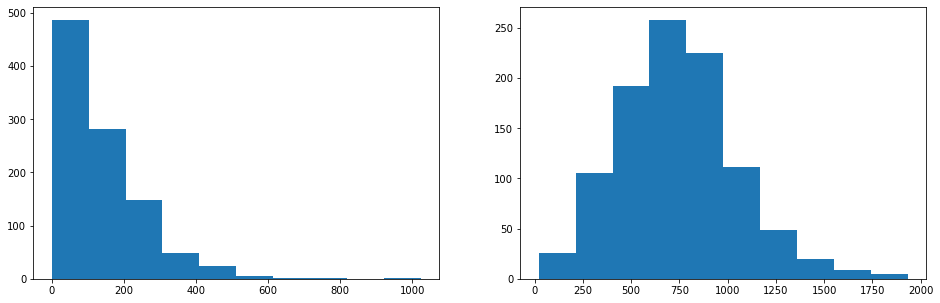

In [7]:
egg_px = []
cope_px = []

for jj in range(len(cope_dataset)):
    img, mask = cope_dataset[jj]

    mask = mask.squeeze()

    # put it on the GPU
    imgtens = torch.from_numpy(img).to('cuda').unsqueeze(0)
    pred = best_model.predict(imgtens)
    pred = (pred.squeeze().cpu().numpy().round())
    
    egg_px.append(np.sum(pred[1, :, :]))
    cope_px.append(np.sum(pred[0, :, :]))

    fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].hist([egg_px, cope_px])
ax[1].hist(cope_px)

Make a few plots

Text(0, 0.5, 'counts')

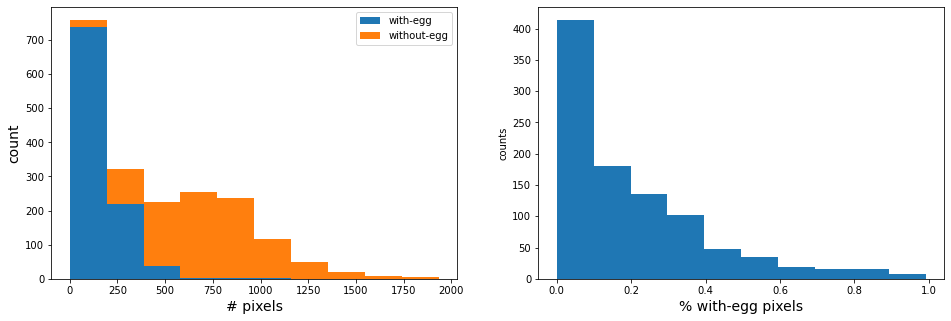

In [25]:
pct_egg = np.asarray(egg_px)/np.asarray(cope_px)
tmp = pct_egg[np.nonzero(pct_egg < 1)]  # ignore the outliers for now

fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].hist([egg_px, cope_px], histtype='barstacked')
ax[0].set_xlabel('# pixels', fontsize=14)
ax[0].set_ylabel('count', fontsize=14)
ax[0].legend(['with-egg', 'without-egg'])
ax[1].hist(tmp)
ax[1].set_xlabel('% with-egg pixels', fontsize=14)
ax[1].set_ylabel('counts')

Zoom in on the 0-200 pixel bin of with-egg pixels

Text(0, 0.5, 'counts')

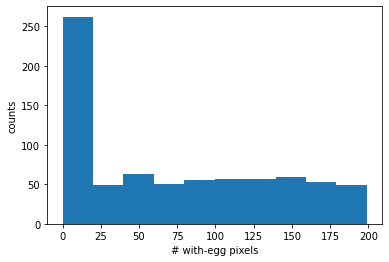

In [32]:
egg_px = np.asarray(egg_px)
tmp = egg_px[np.nonzero(egg_px < 200)]

plt.hist(tmp)
plt.xlabel('# with-egg pixels')
plt.ylabel('counts')

Cumulative histogram of the precent with-egg pixels.

Text(0, 0.5, 'counts')

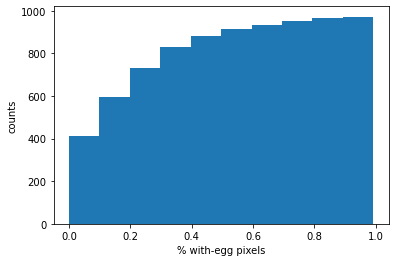

In [34]:
tmp = pct_egg[np.nonzero(pct_egg < 1)]
plt.hist(tmp, cumulative=True)
plt.xlabel('% with-egg pixels')
plt.ylabel('counts')

Do some plotting

index: 849 img-id: 64100985


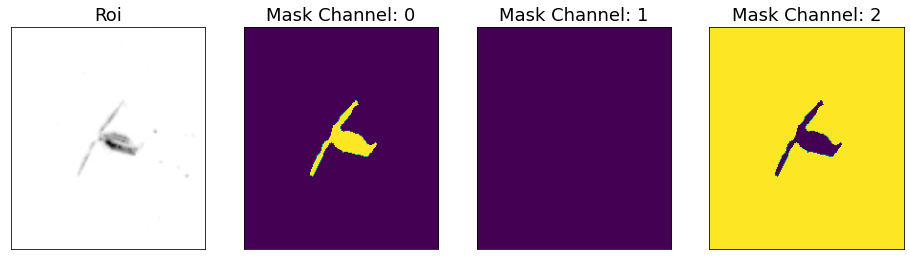

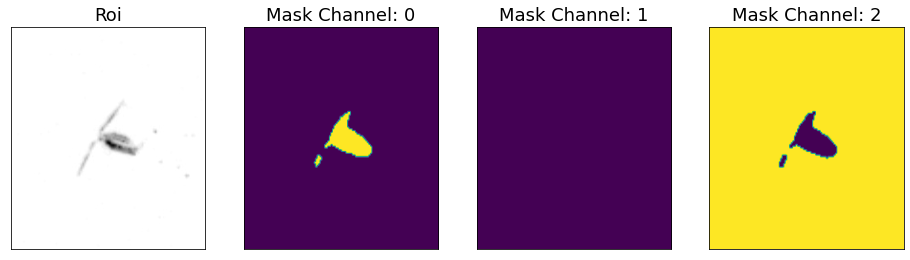

In [31]:
# select a random image from the validation set
ii = np.random.choice(len(cope_dataset))
#ii=10
print('index:', ii, 'img-id:', cope_viz.ids[ii])
img_orig, gt_mask = cope_viz[ii]
img, mask = cope_dataset[ii]

mask = mask.squeeze()

# put it on the GPU
imgtens = torch.from_numpy(img).to('cuda').unsqueeze(0)
pred = best_model.predict(imgtens)
pred = (pred.squeeze().cpu().numpy().round())

# rearrange channels for visualization
pred_out = pred.transpose(1,2,0)
pred_out = cv2.resize(pred_out, dsize=(img_orig.shape[1],img_orig.shape[0]))

visualize(ROI=img_orig, mask=gt_mask)
visualize(ROI=img_orig, mask=pred_out)